In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
#import sklearn as sk
import numpy as np
import math
import os

from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_validate
from sklearn.base import clone
from sklearn import metrics, ensemble, svm

environmental   = pd.read_csv('data/TRAJETORIAS_DATASET_Environmental_dimension_indicators.csv')
socioEconomic   = pd.read_csv('data/TRAJETORIAS_DATASET_Socio-Economic_dimension-indicators.csv')
#epidemiological = pd.read_csv('data/TRAJETORIAS_DATASET_Epidemiological_dimension_indicators.csv')
population      = pd.read_csv('data/TRAJETORIAS_DATASET_Population_indicators.csv')
trajetorias     = pd.read_csv('data/trajetorias_tt.csv', sep=';')

#dfPop = population[population['state'] == 'Pará']
#dfEnv = environmental[environmental['state'] == 'Pará']
#dfEpi = epidemiological[epidemiological['state'] == 'Pará']
#dfSoc = socioEconomic[socioEconomic['state'] == 'Pará']

dfTT = trajetorias

dfPop = population
dfEnv = environmental
#dfEpi = epidemiological
dfSoc = socioEconomic

#years = list(range(1980,2024,1))
print("Dados Socio Econômicos:", dfSoc.year.unique())
print("Dados Ambientais:",dfEnv.period.unique())
#print("Dados Epidemiológicos:",dfEpi.period.unique())

Dados Socio Econômicos: [2000 2010]
Dados Ambientais: [2006 2017]


ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


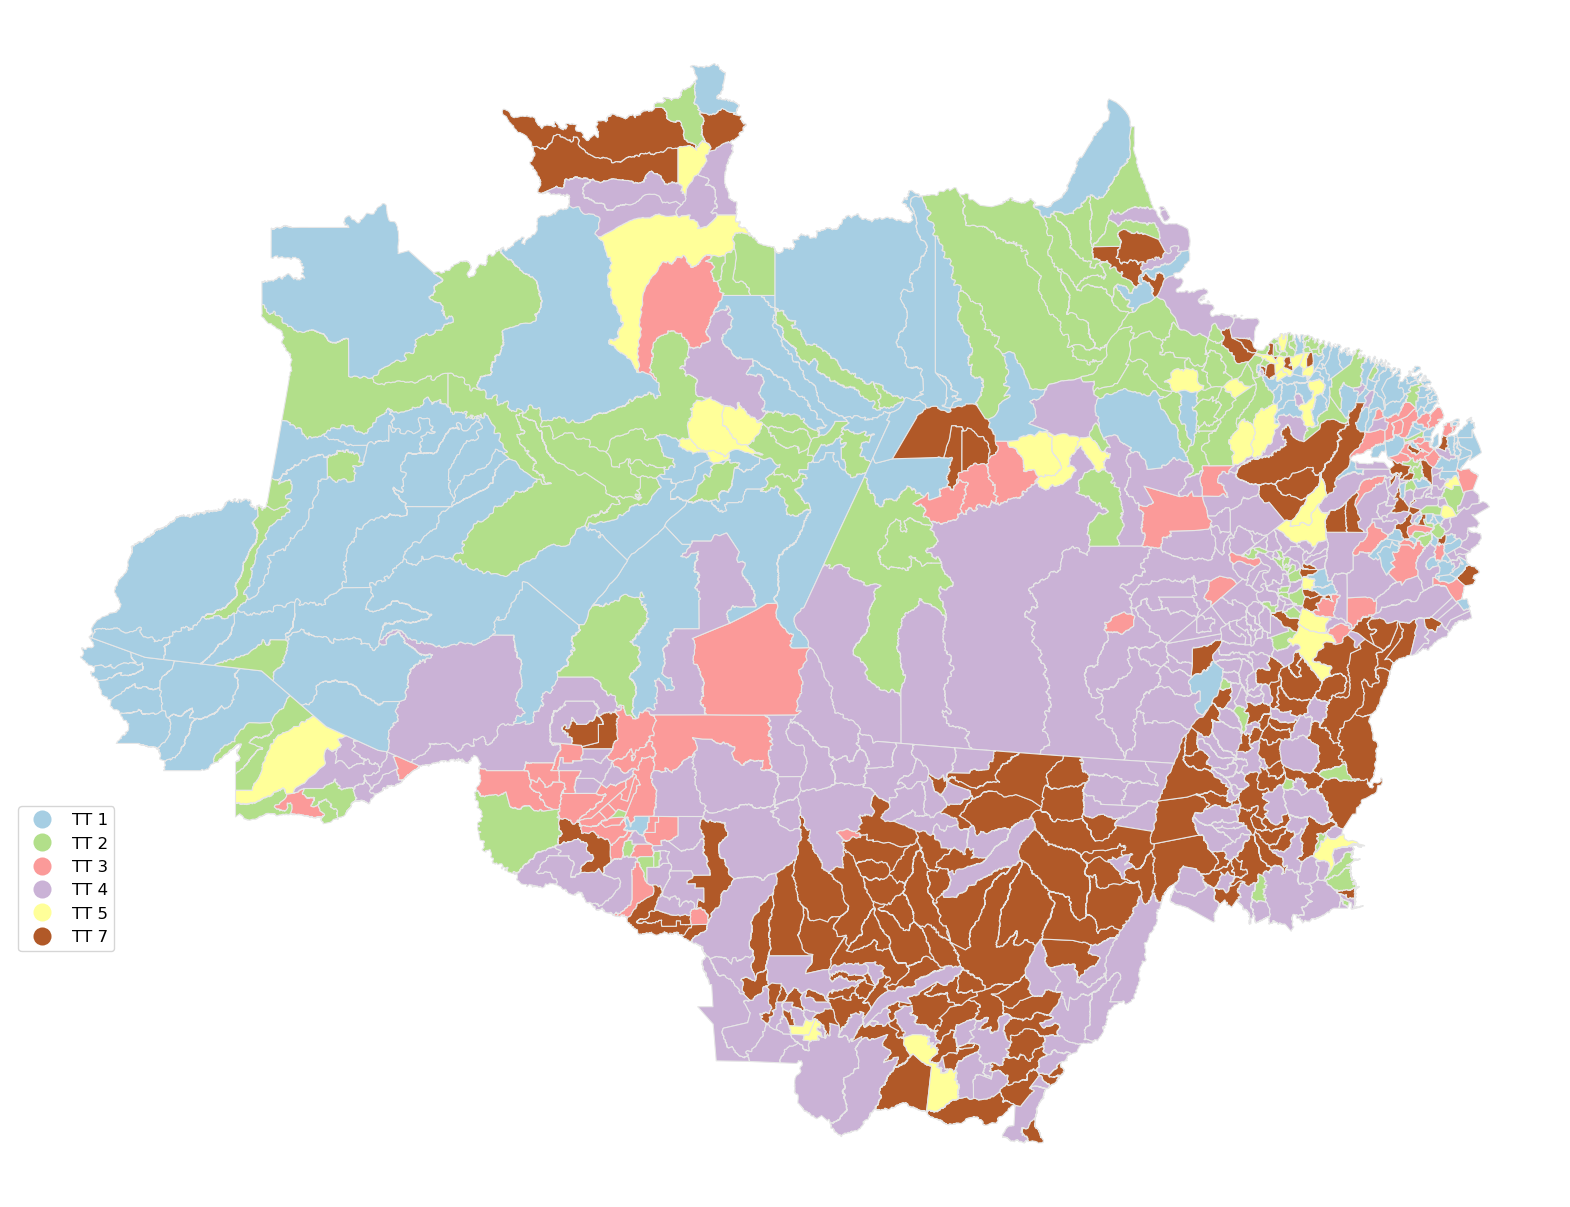

In [2]:

tts = trajetorias.copy()
tts = tts.rename(columns = {'TT17_Dominant':'TT'})
tts = tts.rename(columns = {'cd_geocmu':'CD_MUN'})
tts = tts.drop(columns=['Municipio'])
tts.dropna(subset=['TT'], inplace=True)
tts['TT'] = tts['TT'].astype(int)

map_df = gpd.read_file("./mun_amazonia.shp")
map_df['CD_MUN'] = map_df['CD_MUN'].astype(int)

tt_merged = pd.merge_ordered(map_df, tts, on='CD_MUN')
tt_merged.dropna(subset=['TT'], inplace=True)
tt_merged['TT'] = tt_merged['TT'].astype(int).astype(str).apply(lambda string: 'TT ' + string)

#vmin, vmax = 120, 220# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 20))
ax.axis('off')

legend_kwds = {
    'loc': 'lower left',
    'bbox_to_anchor':(0,0.2),
    'markerscale':1.30,
    'title_fontsize':'large',
    'fontsize':'large'
}

cmap = plt.colormaps['Paired'].resampled(7)

tt_merged.plot(column='TT', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.9', legend=True, legend_kwds=legend_kwds)
plt.savefig('trajetorias_ploted.png')


In [3]:
def absolute_maximum_scale(series):
    return series / series.abs().max()

In [4]:

## OBS:
#  Dados do primeiro intervalo são menos completos
#s

dfSocFil = dfSoc[dfSoc['year'] == 2010]
dfEnvFil = dfEnv[dfEnv['period'] == 2017]

#Não incluido
#dfEpiFil = dfEpi[dfEpi['period'].str.contains('2015-2019')]

dfTT = dfTT.rename(columns = {'TT17_Dominant':'tt'})
dfTT = dfTT.rename(columns = {'cd_geocmu':'geocode_x'})
dfTT = dfTT.drop(columns=['Municipio'])

firstStep = pd.merge_ordered(dfEnvFil, dfSocFil, on='municipality')
secondStep = pd.merge_ordered(firstStep, dfTT, on='geocode_x')
df = secondStep

# Dados geográficos
df.drop(columns=['municipality', 'state_abbrev_x', 'state_abbrev_y', 'state_x',
                 'state_y', 'period', 'year', 'geocode_x', 'geocode_y', 'totpesres'],
        inplace=True)

## Critérios para seleção de features

# 1. São do mesmo dataset
# 2. Manter a mais fácil de coletar
# 3. Disponibilidade temporal

# -> sit não pode ser retirado, pois é a feature importante para o resto da instância de dados
# -> ipm e totpescar são relacionados, mas ambos são importantes
# -> pasture importante também

df = df.drop(columns=['refor', 'road', 'dgorg', 'carpond', 'deorg', 'h', 'a', 'csaude', 'ceduca', 'ccv', 'cnv'])
#df = df.drop(columns=['mining'])

df.dropna(axis=0, subset=['tt'])
df.dropna(subset=['tt'], inplace=True)
df.dropna(subset=['sit'], inplace=True)

di = {"rural": "1", "urbano": "0"}
df = df.replace({"sit": di})

df['sit'] = df['sit'].astype(int)
df['tt'] = df['tt'].astype(int)

#df = df.filter(['fire', 'crop', 'pasture', 'secveg', 'dgfor', 'defor', 'sit', 'tt'])

#for col in df.columns:
#    if col != 'tt':
#        df[col] = absolute_maximum_scale(df[col])
        
df.describe()

,secveg,pasture,crop,urban,core,edge,port,river,mining,fire,dgfor,defor,precp,precn,tempp,sit,ipm,totpescar,tt
count,1564.000000,1564.000000,1564.000000,1564.000000,1564.000000,1552.000000,1564.000000,1564.000000,1564.000000,1564.000000,1350.000000,1356.000000,1564.000000,1564.000000,1564.000000,1564.00000,1564.000000,1564.000000,1564.000000
mean,0.162527,0.359913,0.029873,0.005774,0.279929,59.826546,0.254476,0.820590,0.000239,0.129436,0.120470,0.034025,0.090205,0.420739,1.559571,0.50000,0.054195,1356.365729,3.791560
std,0.139013,0.270315,0.079625,0.028225,0.293603,29.644772,0.779093,1.215685,0.001287,0.167190,0.173909,0.047296,0.366405,1.211573,4.500225,0.50016,0.053453,2197.513310,2.042737
min,0.000649,0.000000,0.000000,0.000000,0.000000,4.191738,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.001074,5.000000,1.000000
25%,0.066382,0.095785,0.000000,0.000456,0.044096,38.417933,0.000000,0.000000,0.000000,0.014072,0.013261,0.003744,0.000000,0.000000,0.352280,0.00000,0.014761,225.000000,2.000000
50%,0.117924,0.359890,0.000363,0.001177,0.153733,55.586531,0.000000,0.338034,0.000000,0.063766,0.049584,0.017125,0.012680,0.007464,0.840487,0.50000,0.033745,603.000000,4.000000
75%,0.225681,0.580987,0.017831,0.003092,0.460015,76.292531,0.000000,1.187533,0.000000,0.168157,0.150895,0.045741,0.064330,0.501704,1.147310,1.00000,0.077110,1490.750000,5.000000
max,0.860949,0.937296,0.630674,0.433523,0.966913,223.874553,12.000000,11.433543,0.016055,0.841699,1.032596,0.375000,6.301130,12.307005,84.753069,1.00000,0.302472,24579.000000,7.000000


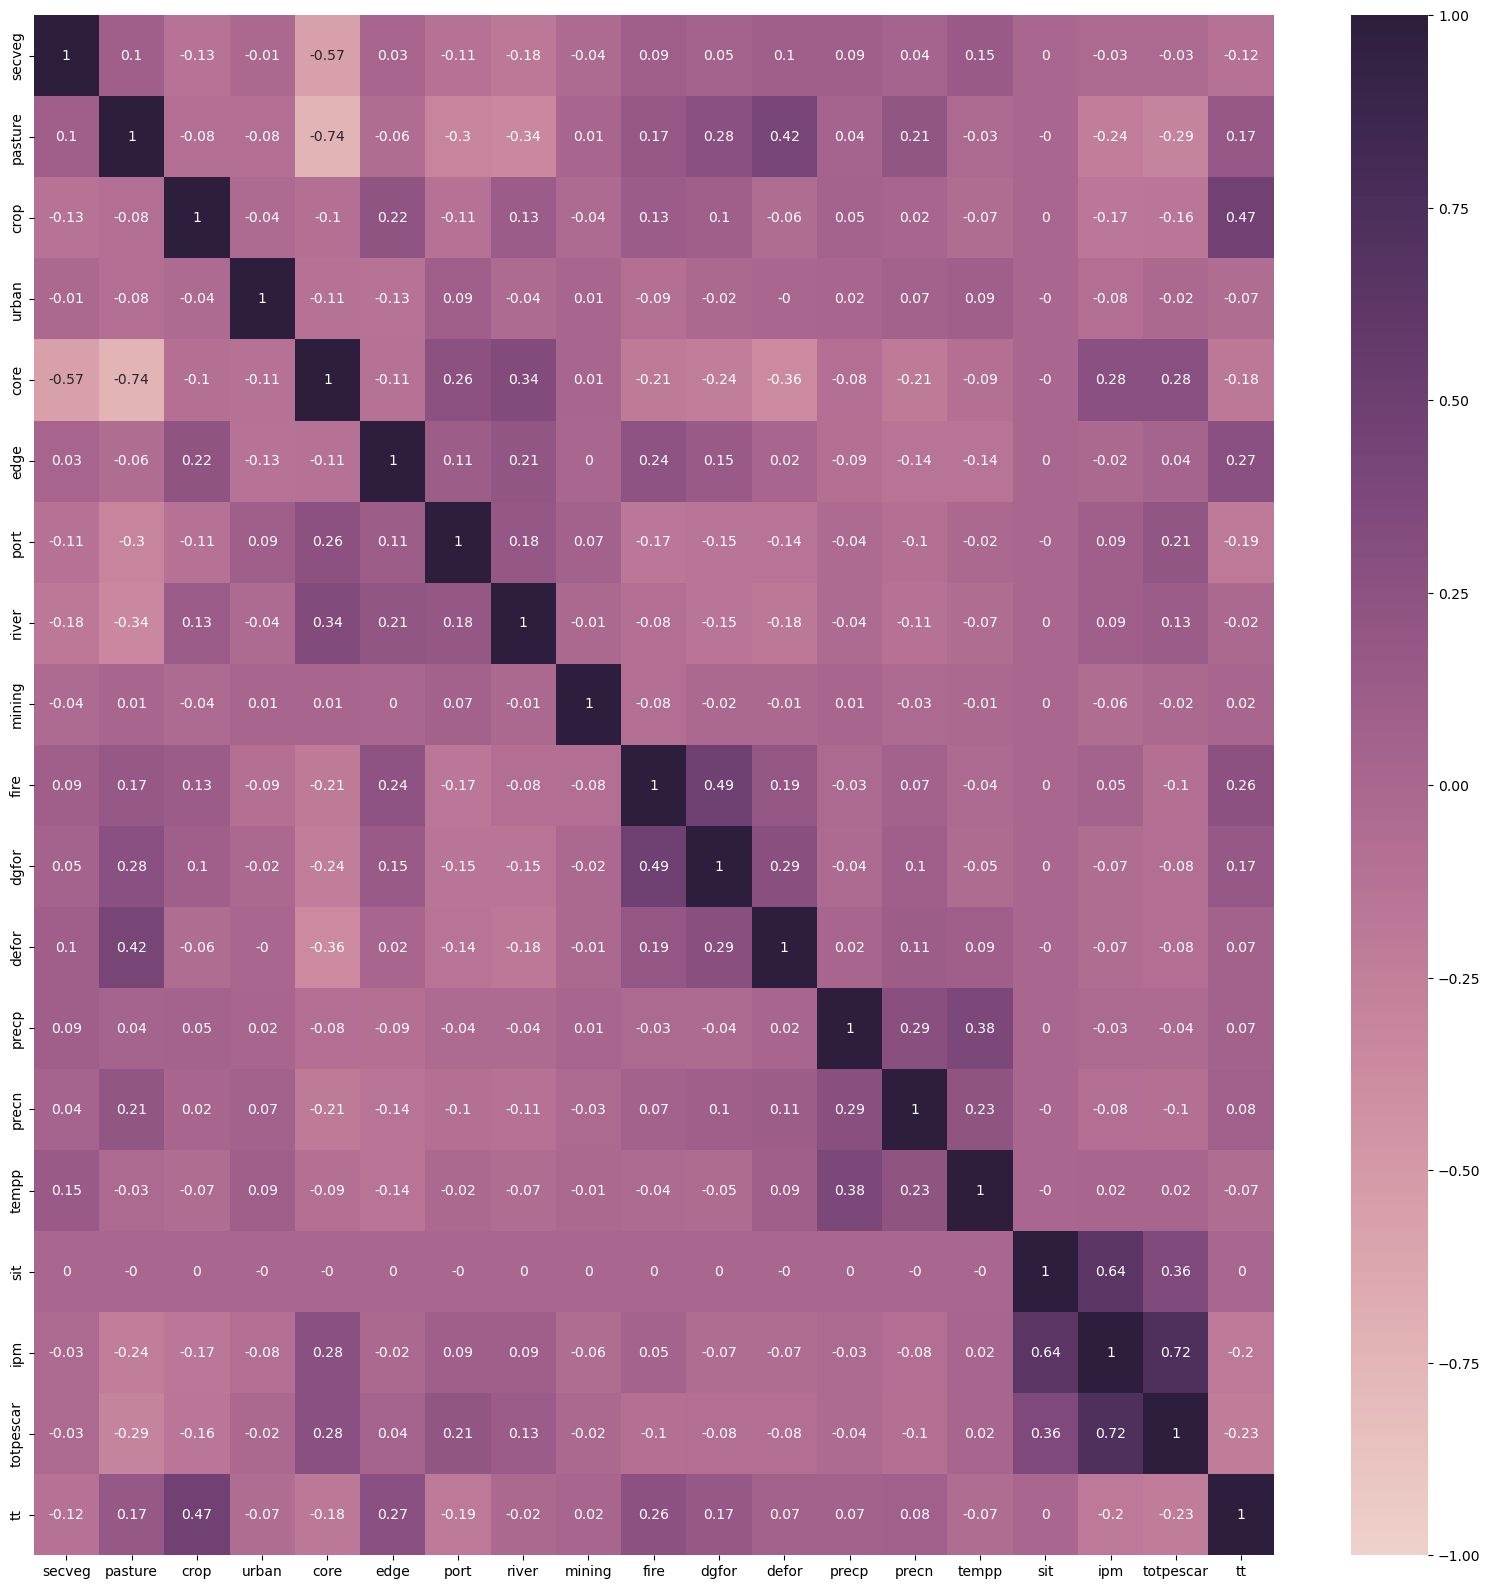

In [5]:
corr_matrix = df.corr().round(2)
#print(corr_matrix_rural)

plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, annot=True, vmax=1, vmin=-1, center=0, cmap=sns.cubehelix_palette(as_cmap=True))
plt.savefig('corr_matrix_df.png')

In [6]:
## Feature Selection - retornar para a célula 3

features = corr_matrix.rename_axis('var').reset_index().melt(id_vars='var')

similarFeatures = []

for _, row in features.iterrows():
    if row['var'] != row['variable'] and row['value'] < -0.5 and row['variable'] != 'sit' and row['var'] != 'sit':
        similarFeatures.append(row)

#df.info()

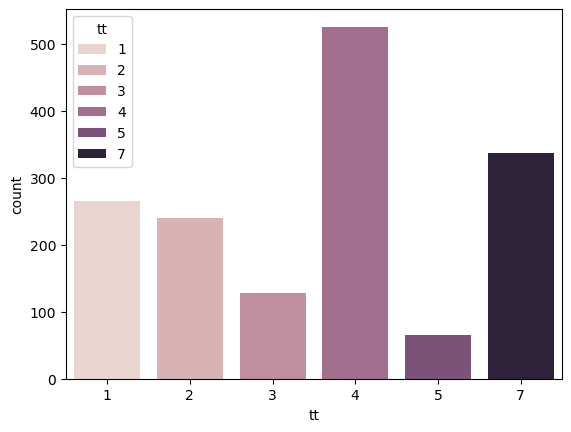

In [7]:
sns.countplot(data=df, x="tt", hue="tt")
plt.savefig('count_classes.png')

In [8]:
## Treinando o classificador

# Separando a variável alvo - tt
df_y = df['tt'] 
df_x = df.drop(columns=['tt'])

# Divisão entre train e test sets
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.33, random_state=42)

# Definição de hiperparâmetros e instanciando o classificador
#parameters = {'n_estimators':list(range(1500,3000)), 'max_depth':[17], 'n_jobs':[-1]}
#clf = GridSearchCV(ensemble.RandomForestClassifier(), parameters, n_jobs=-1)

# Instanciando classificador sem estimar hiperparâmetros
clf = ensemble.RandomForestClassifier(n_estimators=1590, max_depth=17, random_state=0, n_jobs=-1, verbose=0)

clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=17, n_estimators=1590, n_jobs=-1,
                       random_state=0)

Acurácia do modelo: 80.28 %


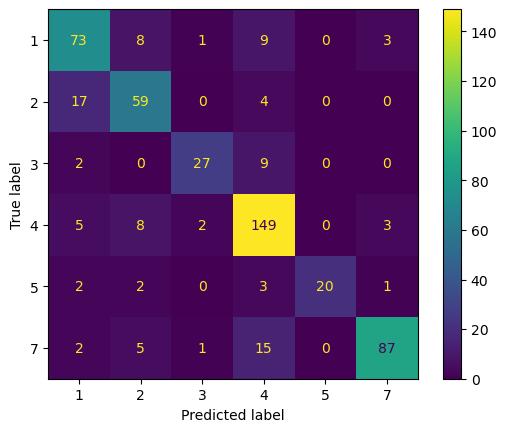

In [9]:
## Resultados

X_test.sort_index(inplace=True)
y_test.sort_index(inplace=True)


y_predict = clf.predict(X_test)


cm = metrics.confusion_matrix(y_test, y_predict, labels=clf.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

disp.plot()
plt.savefig('confusion_matrix_df.png')
print('Acurácia do modelo:', math.ceil(metrics.accuracy_score(y_test, y_predict) * 10000)/100, '%')


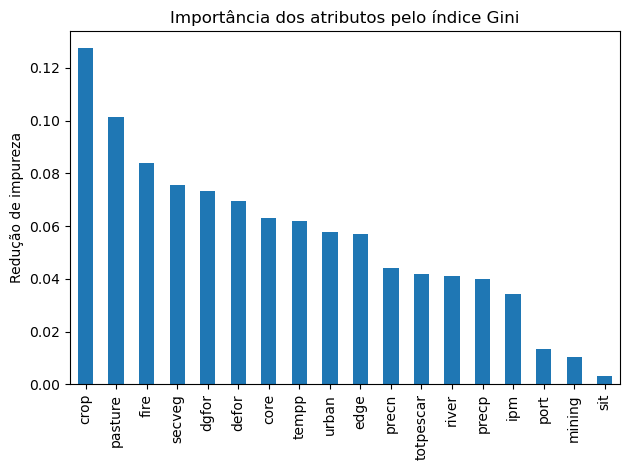

In [10]:
forest_importances = pd.Series(clf.feature_importances_, index=df_x.columns.values)
fi = pd.Series.sort_values(forest_importances, ascending=False)

fig, ax = plt.subplots()
fi.plot.bar(ax=ax)
ax.set_title("Importância dos atributos pelo índice Gini")
ax.set_ylabel("Redução de impureza")
fig.tight_layout()
plt.savefig('feature_importance.png')

In [11]:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 17,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 1590,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [12]:
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import StratifiedKFold

skfolds = StratifiedKFold(n_splits=10) 

i = 0
for train_index, test_index in skfolds.split(df_x, df_y):
    clone_clf = ensemble.RandomForestClassifier(n_estimators=1590, max_depth=17, random_state=0, n_jobs=-1, verbose=0)
    
    X_train_folds = df_x.iloc[train_index]
    y_train_folds = df_y.iloc[train_index]
    X_test_fold = df_x.iloc[test_index]
    y_test_fold = df_y.iloc[test_index]

    #print(y_train_folds.value_counts())
    #print(y_test_fold.value_counts())
    #X_train_folds.info()
    #X_test_fold.info()
    
    clone_clf.fit(X_train_folds, y_train_folds)
    
    y_pred = clone_clf.predict(X_test_fold)
    print('Acurácia do modelo:', f'{metrics.accuracy_score(y_test_fold, y_pred):.2f}%')
    print('\nRelatório de Classificação:\n', metrics.classification_report(y_test_fold, y_pred))
        
    cm2 = metrics.confusion_matrix(y_test_fold, y_pred, labels=clf.classes_)
    disp2 = metrics.ConfusionMatrixDisplay(confusion_matrix=cm2, cmap=sns.cubehelix_palette(as_cmap=True), display_labels=clf.classes_)
    
    disp2.plot()
    i = i+1
    plt.savefig(f'confusion_matrix_{i}.png')



Acurácia do modelo: 0.46%

Relatório de Classificação:
               precision    recall  f1-score   support

           1       0.40      0.38      0.39        26
           2       0.16      0.21      0.18        24
           3       0.32      0.54      0.40        13
           4       0.63      0.79      0.70        53
           5       0.00      0.00      0.00         7
           7       0.82      0.26      0.40        34

    accuracy                           0.46       157
   macro avg       0.39      0.36      0.35       157
weighted avg       0.51      0.46      0.45       157



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TypeError: ConfusionMatrixDisplay.__init__() got an unexpected keyword argument 'cmap'

In [ ]:
from sklearn.model_selection import cross_validate

# Aplicando a validação cruzada com 10 folds
resultados = cross_validate(clf, df_x, df_y, cv=10, return_train_score=True)
#scoring='accuracy', 
# Extraindo as métricas
acuracia_treino = resultados['train_score']
acuracia_teste = resultados['test_score']

# Exibindo os resultados de forma elegante
print("="*50)
print("Resultados da Validação Cruzada com 10 Folds")
print("="*50)
for i in range(len(acuracia_treino)):
    print(f"Fold {i+1}:")
    print(f"    Acurácia no Treino: {acuracia_treino[i]:.2f}")
    print(f"    Acurácia no Teste: {acuracia_teste[i]:.2f}")
    print("-"*50)

print(f"Acurácia Média no Treino: {acuracia_treino.mean():.2f} ± {acuracia_treino.std():.2f}")
print(f"Acurácia Média no Teste: {acuracia_teste.mean():.2f} ± {acuracia_teste.std():.2f}")
print("="*50)